In [8]:
import argparse
import os

import torch
import torch.utils.data

import model.transformer
import model.trainer as trainer
import utils.datasets
import utils.utils
import utils.plots as plots
import utils.counting as counting
import torchvision
import numpy as np
import warnings
from matplotlib import pyplot as plt

import utils.anchors
import cv2

import time
import pandas as pd

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import rasterio as rio
import json

root = '/home/a01328525/'
#root = 'E:/Experiments/'
folder_maps = root+'Datasets Maps/'
folder_save_results = root+'Counting images paper/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
import shutil
shutil.make_archive("/home/a01328525/transformer_object_dectection", 'zip', "/home/a01328525/transformer_object_dectection")

#shutil.make_archive("/home/a01328525/trained_models", 'zip', "/home/a01328525/Datasets_STED/runs_transformers")

'/home/a01328525/transformer_object_dectection.zip'

correction RGB 0.400
correction RGB 0.400
correction RGB 0.344
correction RGB 0.312
correction RGB 0.377


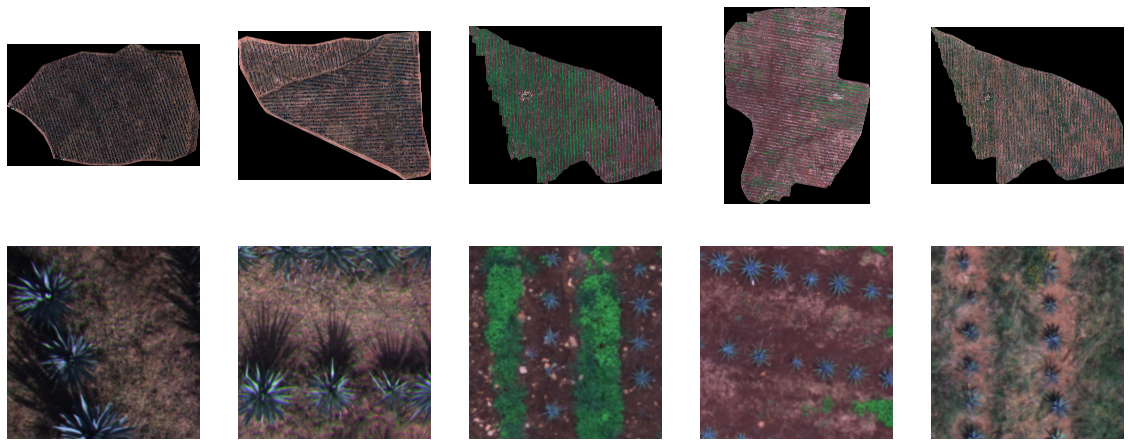

In [25]:
plt.figure(figsize=(4*5, 4*2))

zone_names=['Zone1', 'Zone3', 'Zone108','Zone109', 'Zone108_octubre']

f = open(root+'zone_parameters.json'); zone_parameters = json.load(f); f.close()

for i, zone_name in enumerate(zone_names):
    map_dir = folder_maps+zone_name+'_full.tif'
                  
    with rio.open(map_dir) as img :
        imgnp = img.read() 
    B = imgnp[0,:,:]; 
    G = imgnp[1,:,:]
    R = imgnp[2,:,:]
    Re = imgnp[3,:,:]
    NIR = imgnp[4,:,:]
    
    img = cv2.merge((R, G, B))
    correctionRGB = zone_parameters[zone_name]['correctionRGB']
    correctionRGB = np.clip(correctionRGB, 0, 0.4)
    print("correction RGB %0.3f"%(correctionRGB))
    img = (255*img/correctionRGB).astype('uint8')
      
    #load fraction 
    frac_size = 224
    center = np.array(B.shape)//2
    coords = np.array([center-frac_size//2, center+frac_size//2]) #x1y1x2y2
    frac_img = img[coords[0, 0]:coords[1, 0], coords[0, 1]:coords[1, 1], :]
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img); plt.axis('off')
    
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(frac_img); plt.axis('off')

plt.savefig(folder_save_results+'orthophotos.png', format="png", dpi=400)

In [26]:
img.shape

(5757, 7033, 3)

In [170]:
channel_selection = 'bgr'#'bgr_vis'#'bgr'
model_dir = root+"Datasets_STED/runs_transformers/STED_101_nano_cbbox_bgr_diou_BitNet/best.pt"
N_channels = 3
n_model = 128
num_blks = 1
loss_type = 'diou'
obj = 'cbbox'
conf_thr = 0.4; iou_thr=0.5; diou_thr=0.5

batch_size=64 
augment = False
probAugment = 0

train_dataloader, test_dataloader = trainer.get_dataloaders(root+'/Datasets_YOLO/Zones_cbbox_dataset_10/', obj,
                                                    augment, probAugment, batch_size)

Load train data with 2440 images
Load val data with 1377 images


In [171]:
for i in test_dataloader:
    P, imgs, targets =  i
    break
print(imgs.shape)
#np.unique(targets[:,-1])
targets.shape

torch.Size([64, 3, 224, 224])


torch.Size([540, 5])

In [13]:
heatmap1, grays1, masks1 = plots.get_data_atts(imgs, 'encoder1', model_dir, N_channels, n_model, num_blks, 
                                  loss_type, obj, conf_thr, iou_thr, diou_thr, 
                                  img_size=224, reduction='mean', device='cuda')
#masked.shape
print(heatmap1.shape)
print(masks1.shape)

heatmap2, grays2, masks2 = plots.get_data_atts(imgs, 'encoder2', model_dir, N_channels, n_model, num_blks, 
                                  loss_type, obj, conf_thr, iou_thr, diou_thr, 
                                  img_size=224, reduction='mean', device='cuda')
#masked.shape
print(heatmap2.shape)
print(masks2.shape)

Model loaded
(9, 224, 224, 3)
(9, 224, 224, 3)
Model loaded
(9, 224, 224, 3)
(9, 224, 224, 3)


In [14]:
imgs[0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

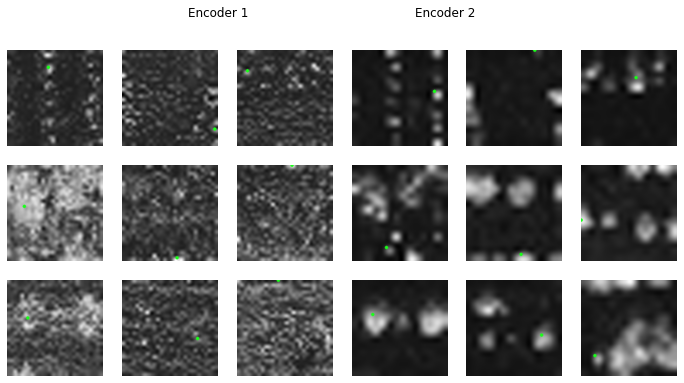

In [15]:
rows, cols = 3, 6
im_plot_size = 2
plt.figure(figsize=(cols*im_plot_size, rows*im_plot_size))

plt.suptitle('Encoder 1                                           Encoder 2')
for i in range(rows):
    for j in range(cols//2):
        #print(i*(rows)+j)
        #print(i*(rows+cols//2)+j)
        plt.subplot(rows, cols, i*(rows+cols//2)+j+1)
        plt.imshow(grays1[i*rows+j,...]); plt.axis('off')
        
        plt.subplot(rows, cols, i*(rows+cols//2)+cols//2+j+1)
        plt.imshow(grays2[i*rows+j,...]); plt.axis('off')

plt.savefig(folder_save_results+'attentions.png', format="png", dpi=400)

In [187]:
selected_img = 24
P[24]

'/home/a01328525//Datasets_YOLO/Zones_cbbox_dataset_10/val/images/0381.tif'

In [200]:
import model.transformer
model = model.transformer.TransformerObjectDetection(224, N_channels, n_model, num_blks, 
                                                     obj = obj, loss_type= loss_type, device=device, bitNet=True).to(device)
checkpoint = torch.load(model_dir, map_location=torch.device(device))
if type(checkpoint) == dict:
    model.load_state_dict(checkpoint['model'])
else:
    model.load_state_dict( checkpoint )
print("Model loaded")

imgs = imgs.to(device)
boxes, scores  = counting.inference(model, imgs[selected_img].unsqueeze(0), obj, conf_thr, diou_thr, adjust_ij=(0, 0), xyxy=False, device=device)
boxes

#heatmap, grays, masks = plots.get_map_att(model.encoder1, imgs.to('cpu'), boxes, reduction='mean')

Model loaded


[tensor([[154.6230,  22.4634,  31.0907],
         [189.0829,  93.3396,  15.5065],
         [215.1410, 171.3041,   9.5438],
         [ 76.4798, 187.7669,  38.4867],
         [ 28.4696,  76.7650,  29.1498]], device='cuda:0')]

In [207]:
batch_size = 1
img_size = (224, 224)#imgs.shape[-2:]

cls_rollout = plots.attention_rollout(model.encoder2, 'mean') #batch_size, n patches, n patches
n_patches = cls_rollout.shape[1]
grid_size = int(np.sqrt(n_patches))
cls_rollout.shape

torch.Size([1, 196, 196])

In [208]:
boxes

[tensor([[154.6230,  22.4634,  31.0907],
         [189.0829,  93.3396,  15.5065],
         [215.1410, 171.3041,   9.5438],
         [ 76.4798, 187.7669,  38.4867],
         [ 28.4696,  76.7650,  29.1498]], device='cuda:0')]

In [209]:
import torch.nn.functional as F
import cv2

# Blue color in BGR
color = (1)

# font
font = cv2.FONT_HERSHEY_SIMPLEX

# org
org = (10, 15)

# fontScale
fontScale = 0.5
# Line thickness of 2 px
thickness = 2

grid_size = int(np.sqrt(cls_rollout.shape[-1]))
atts_map = np.zeros((n_patches, img_size[0], img_size[1])) #[batch_size, n patches]
#print(temp.shape)

sc = img_size[0]/grid_size
for i in range(cls_rollout.shape[-1]):
    minimo, maximo = cls_rollout[0,i,:].min(), cls_rollout[0,i,:].max()
    
    #print(cls_rollout[i,selected_tokens[i],:].shape)
    temp = (cls_rollout[0,i,:]-minimo)/(maximo-minimo)#scale 0 to 1 each image of the batch
    
    temp = F.interpolate (temp.view(-1, 1, grid_size, grid_size), (img_size[0], img_size[1]), mode='bicubic') # upsample to original image size
    temp = (temp-temp.min())/(temp.max()-temp.min())#scale 0 to 1
    
    x = int(sc*(i%grid_size)) #it goes left to right
    y = int(sc*(i//grid_size)) #it goes up to down    
    #print(temp.shape)
    temp = np.float32(np.array(temp[0,0,...]))
    #print(temp.shape)
    temp  = cv2.circle(temp, (x,y), radius=0, color=(0.5, 1, 0.1), thickness=8)
    #print(temp.shape)
    atts_map[i,...] = temp
    
    # Using cv2.putText() method
    cv2.putText(atts_map[i], str(i), org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
atts_map.shape

(196, 224, 224)

In [210]:
atts_map2 = atts_map

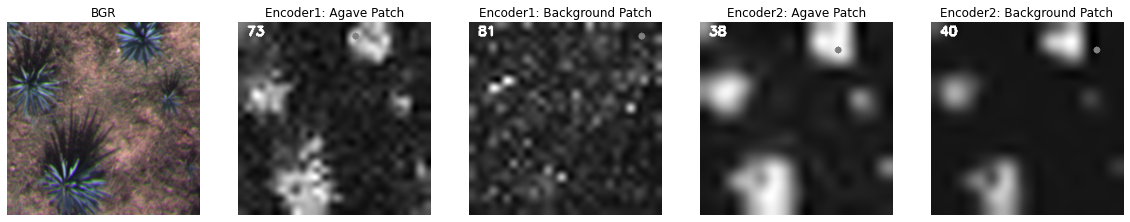

In [217]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.imshow((imgs[selected_img]/imgs[selected_img].max()).permute(1, 2, 0).cpu()[:, :, [2, 1, 0]]); plt.axis('off')
plt.title('BGR')

plt.subplot(1, 5, 2)
plt.imshow(atts_map1[73], cmap='gray'); plt.axis('off')
plt.title('Encoder1: Agave Patch')

plt.subplot(1, 5, 3)
plt.imshow(atts_map1[81], cmap='gray'); plt.axis('off')
plt.title('Encoder1: Background Patch')

plt.subplot(1, 5, 4)
plt.imshow(atts_map2[38], cmap='gray'); plt.axis('off')
plt.title('Encoder2: Agave Patch')

plt.subplot(1, 5, 5)
plt.imshow(atts_map2[40], cmap='gray'); plt.axis('off')
plt.title('Encoder2: Background Patch')

plt.savefig(folder_save_results+'Atts_patches.png', format="png", dpi=400)

In [191]:
import imageio
images = []
for i in range(196):
    images.append((255*atts_map[i]).astype('uint8'))

# Save the images as a gif
imageio.mimsave(root+'Counting images paper/atts3.gif', images, fps=5)

# detections sample

In [6]:
img_size = 224

folder_maps = root+'Datasets Maps/'
folder_tiles = root+'Datasets Tiles/'
folder_trained_models = root+"Datasets_STED/runs_transformers/"

zone_name='Zone108_octubre'
#zone_name='Zone3'
#zone_name='Zone102_part1'
loss_type = 'diou' #used for all models

models_dir = [
                folder_trained_models+"STED_101_nano_cbbox_bgr_diou_BitNet/best.pt"
                #folder_trained_models+"STED_122_nano_bbox_bgr_diou_BitNet/best.pt"
                #folder_trained_models+"STED_101_nano_cbbox_bgr_diou_BitNet/best.pt"
            ]
map_dir =   folder_maps+zone_name+'_full.tif'

conf_thr = 0.4 #filter scores to consider only predictions with confidence score greater than conf_thr
iou_thr = 0.5#0.15# using diou #0.5
diou_thr = 0.5#0.15# using diou #0.5

results = [] #to save results to plot each model visualization

imgnp = counting.read_orthomap_full(map_dir)
print("Orthomap full read")

for model_dir in models_dir:
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    n_model, num_blks, obj, N_channels, channels, loss_type, bitNet = counting.get_model_pars_from_dir(model_dir)
    
    result = counting.get_boxes_fraction_map(model_dir, imgnp, N_channels, n_model, num_blks, loss_type, obj, 
                                           channels, conf_thr, iou_thr, diou_thr, img_size, device, bitNet=bitNet, frac_size=336)
    #imgnp, all_boxes, all_scores, boxes_filtered, scores_filtered, preds_boxes_test, preds_scores_test, imgs_test = results
    results.append(result)

Orthomap read at /home/a01328525/Datasets Maps/Zone108_octubre_full.tif
Orthomap full read
Model loaded
Fraction map loaded: (10, 5757, 7033)
 Tile  224: 336,  224: 336, Objects Detected:   2
All boxes detected: 82
Boxes filtered detected: 31


(336, 336, 3)
(336, 336, 3)


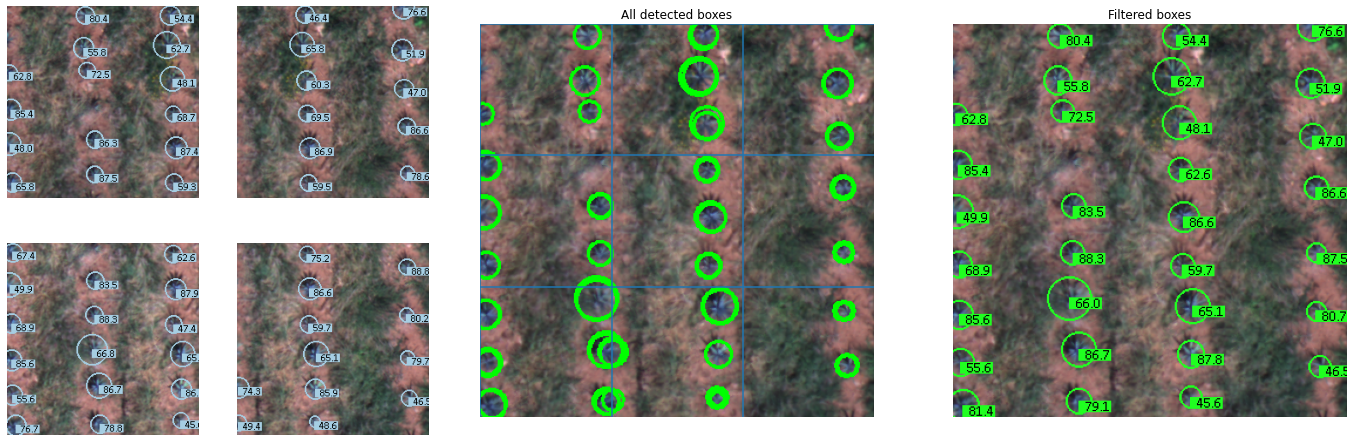

In [7]:
imgnp, all_boxes, all_scores, boxes_filtered, scores_filtered, preds_boxes_test, preds_scores_test, imgs_test, obj = results[0]
plots.plot_model_test(preds_boxes_test, preds_scores_test, imgs_test, imgnp, obj, all_boxes, boxes_filtered, scores_filtered)
plt.savefig(folder_save_results+'NMSarea.png', format="png", dpi=400)

# Counting Evaluation

In [6]:
data

array([3.343000e+03, 3.606000e+03, 2.572865e+07, 1.029250e+02,
       2.207000e+01, 8.086000e+01, 3.030000e+03, 3.231000e+01,
       1.757000e+03, 0.000000e+00, 9.000000e+00, 9.068000e+01,
       9.782000e+01, 9.411000e+01, 9.024000e+01, 9.734000e+01,
       9.365000e+01, 8.796000e+01, 9.488000e+01, 9.129000e+01,
       8.403000e+01, 9.064000e+01, 8.721000e+01, 4.872000e+01,
       5.256000e+01, 5.057000e+01, 3.270000e+03, 7.300000e+01,
       3.360000e+02, 3.254000e+03, 8.900000e+01, 3.520000e+02,
       3.172000e+03, 1.710000e+02, 4.340000e+02, 3.030000e+03,
       3.130000e+02, 5.760000e+02, 1.757000e+03, 1.586000e+03,
       1.849000e+03])

## Plots

In [20]:
img_size = 224

folder_maps = root+'Datasets Maps/'
folder_tiles = root+'Datasets Tiles/'
folder_save_results = root+'Counting images paper/'
folder_trained_models = root+"Datasets_STED/runs_transformers/"

#zone_name='Zone108_octubre'
zone_name='Zone3'
#zone_name='Zone102_part1'
loss_type = 'diou' #used for all models

models_dir = [
                folder_trained_models+"STED_101_nano_cbbox_bgr_diou_BitNet/best.pt"
                #folder_trained_models+"STED_101_nano_cbbox_bgr_diou_BitNet/best.pt"
            ]
map_dir =   folder_maps+zone_name+'_full.tif'

conf_thr = 0.4 #filter scores to consider only predictions with confidence score greater than conf_thr
iou_thr = 0.5#0.15# using diou #0.5
diou_thr = 0.5#0.15# using diou #0.5

results = [] #to save results to plot each model visualization

imgnp = counting.read_orthomap_full(map_dir)
print("Orthomap full read")

for model_dir in models_dir:
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    n_model, num_blks, obj, N_channels, channels, loss_type, bitNet = counting.get_model_pars_from_dir(model_dir)
    
    result = counting.get_boxes_fraction_map(model_dir, imgnp, N_channels, n_model, num_blks, loss_type, obj, 
                                           channels, conf_thr, iou_thr, diou_thr, img_size, device, bitNet=bitNet, frac_size=336)
    #imgnp, all_boxes, all_scores, boxes_filtered, scores_filtered, preds_boxes_test, preds_scores_test, imgs_test = results
    results.append(result)

Orthomap read at /home/a01328525/Datasets Maps/Zone3_full.tif
Orthomap full read
Model loaded
Fraction map loaded: (10, 7366, 9529)
 Tile  224: 336,  224: 336, Objects Detected:   1
All boxes detected: 27
Boxes filtered detected: 10


(336, 336, 3)
(336, 336, 3)


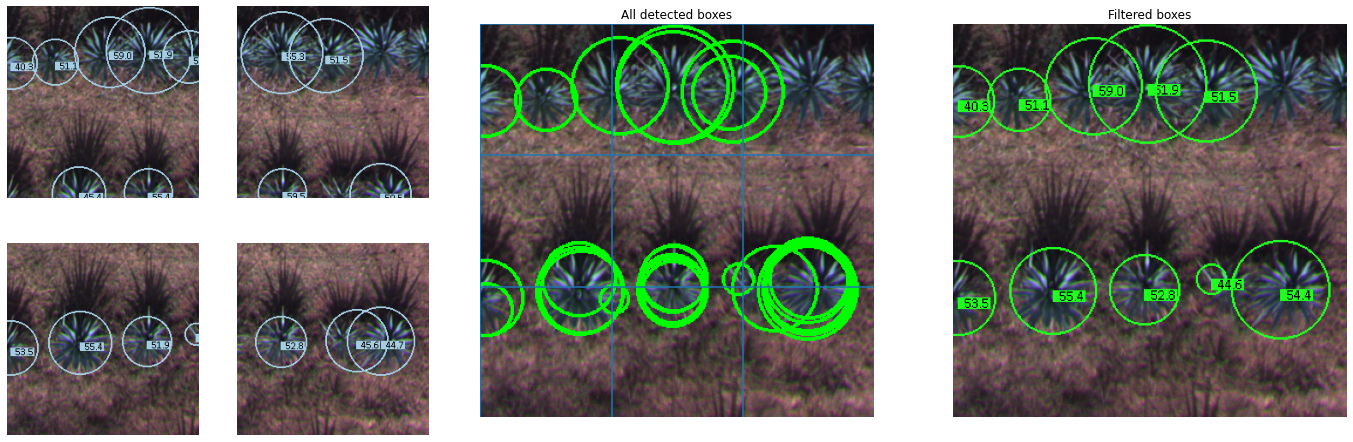

In [22]:
imgnp, all_boxes, all_scores, boxes_filtered, scores_filtered, preds_boxes_test, preds_scores_test, imgs_test, obj = results[0]
plots.plot_model_test(preds_boxes_test, preds_scores_test, imgs_test, imgnp, obj, all_boxes, boxes_filtered, scores_filtered)
plt.savefig(folder_save_results+'NMSarea2.png', format="png", dpi=400)

2578 3178 3216 3816


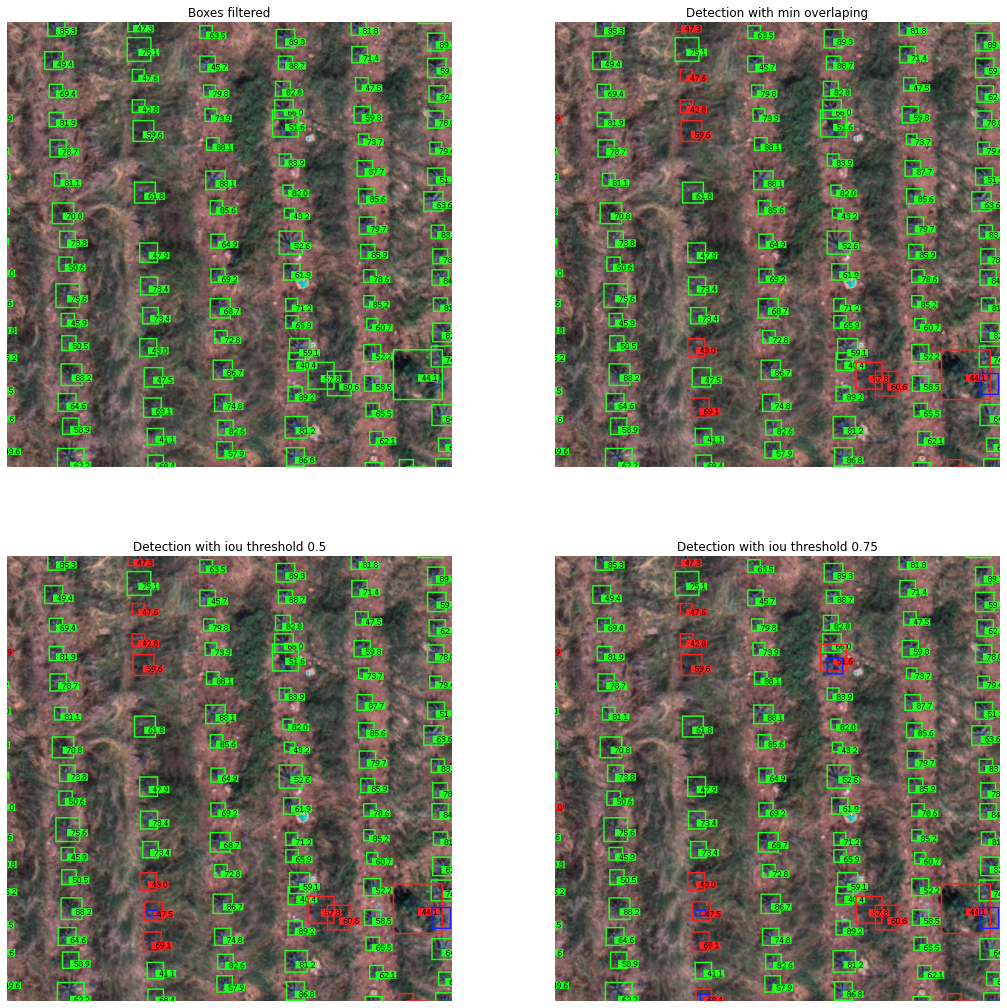

In [18]:
ind = 0
(zone_name, boxes_filtered, scores_filtered, boxes_gt, TP_index, FP_index, FN_index, TP_index2, FP_index2, FN_index2, TP_index3, FP_index3, FN_index3, TP_index4, FP_index4, FN_index4, TP_index5, FP_index5, FN_index5, obj) =final_results[ind]
f = open(root+'zone_parameters.json'); zone_parameters = json.load(f); f.close()
correctionRGB = zone_parameters[zone_name]['correctionRGB']

frac_size=600
plots.plot_model_eval(imgnp.transpose(1, 2, 0)[:,:,0:3], correctionRGB, obj, boxes_filtered, scores_filtered, boxes_gt, TP_index, FP_index, FN_index, TP_index2, FP_index2, FN_index2, TP_index3, FP_index3, FN_index3, frac_size)

In [24]:
folder_save_results = root+'Counting paper images/'
folder_save_results = None

In [ ]:
def plot_train_losses(dir_losses, title, start_epoch=0, y_max=5, folder_to_save=None, dpi=400):
    linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
    
    df = pd.read_csv(dir_losses)
    losses_train = df['Losses train'][start_epoch:]
    times_train = df['Times train'][start_epoch:]*1000 #ms
    losses_eval = df['Losses eval'][start_epoch:]
    times_eval = df['Times eval'][start_epoch:]*1000 #ms
    l1_losses_box = df['L1 Losses cbbox'][start_epoch:]
    l1_losses_conf = df['L1 Losses conf'][start_epoch:]
    l2_losses_box = df['L2 Losses cbbox'][start_epoch:]
    l2_losses_conf = df['L2 Losses conf'][start_epoch:]

    epochs=len(losses_train)
    x = range(1,epochs+1)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 9))
    plt.rcParams.update({'font.size': 10})
    #times = np.array(losses)/2

    ax1 = axs[0][0]
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.plot(x, losses_train, color=color, linestyle=linestyles['densely dashed'], label="Loss train")
    color = 'tab:blue'
    ax1.plot(x, losses_eval, color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
    ax1.tick_params(axis='y')
    ax1.legend(loc="upper left")
    ax1.axis(ymin=0, ymax=y_max)
    
    y2 = min(losses_eval)
    x2 = x[list(losses_eval).index(y2)]
    ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-epochs/4,y2+y_max/7), weight="bold", arrowprops={'width':0.05})
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('time (ms)')  # we already handled the x-label with ax1
    ax2.plot(x, times_train, color=color, linestyle=linestyles['densely dashed'], label='Avg time for train epoch')
    color = 'tab:pink'
    ax2.plot(x, times_eval, color=color, linestyle=linestyles['densely dashdotdotted'], label='Avg time for eval epoch')
    ax2.tick_params(axis='y')
    ax2.legend(loc="upper right")
    ax2.set_title('Lossess for all epochs')
    
    ax2 = axs[1][0]
    ax2.set_ylabel('loss')
    color = 'tab:orange'
    ax2.plot(x, l1_losses_box, color=color, linestyle=linestyles['loosely dashdotdotted'], label="L1 Loss Box")
    color = 'tab:purple'
    ax2.plot(x, l1_losses_conf, color=color, linestyle=linestyles['densely dashed'], label="L1 Loss Conf")
    color = 'tab:orange'
    ax2.plot(x, l2_losses_box, color=color, linestyle=linestyles['loosely dashed'], label="L2 Loss Box")
    color = 'tab:purple'
    ax2.plot(x, l2_losses_conf, color=color, linestyle=linestyles['densely dashdotdotted'], label="L2 Loss Conf")
    ax2.legend(loc="upper left")
    ax2.set_title('Components of training losses for all epochs')
    ax2.axis(ymin=0, ymax=y_max)

    start_plot = 2*epochs//3
    ax1 = axs[0][1]
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.plot(x[start_plot:], losses_train[start_plot:], color=color, linestyle=linestyles['densely dashed'], label="Loss train")
    color = 'tab:blue'
    ax1.plot(x[start_plot:], losses_eval[start_plot:], color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
    ax1.tick_params(axis='y')
    ax1.legend(loc="upper left")
    
    y_min2 = 0.9*min(losses_eval[start_plot:].min(), losses_train[start_plot:].min())
    y_max2 = 1.1*max(losses_eval[start_plot:].max(), losses_train[start_plot:].min())
    ax1.axis(ymin=y_min2, ymax=y_max2)
    ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-(epochs-start_plot)/4,y2+(y_max2-y_min2)/4), weight="bold", arrowprops={'width':0.05})
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('time (ms)')  # we already handled the x-label with ax1
    ax2.plot(x[start_plot:], times_train[start_plot:], color=color, linestyle=linestyles['densely dashed'], label='Avg train epoch')
    color = 'tab:pink'
    ax2.plot(x[start_plot:], times_eval[start_plot:], color=color, linestyle=linestyles['densely dashdotdotted'], label='Avg eval epoch')
    ax2.tick_params(axis='y')
    ax2.legend(loc="upper right")
    ax2.set_title('Losses for last epochs')
    
    ax2 = axs[1][1]
    ax2.set_ylabel('loss')
    color = 'tab:orange'
    ax2.plot(x[start_plot:], l1_losses_box[start_plot:], color=color, linestyle=linestyles['loosely dashdotdotted'], marker='o', label="L1 Loss Box")
    color = 'tab:purple'
    ax2.plot(x[start_plot:], l1_losses_conf[start_plot:], color=color, linestyle=linestyles['densely dashed'], marker='o', label="L1 Loss Conf")
    color = 'tab:orange'
    ax2.plot(x[start_plot:], l2_losses_box[start_plot:], color=color, linestyle=linestyles['loosely dashed'], marker='+', label="L2 Loss Box")
    color = 'tab:purple'
    ax2.plot(x[start_plot:], l2_losses_conf[start_plot:], color=color, linestyle=linestyles['densely dashdotdotted'], marker='+', label="L2 Loss Conf")
    ax2.legend(loc="upper left")
    ax2.set_title('Components of training losses for last epochs')
    
    fig.suptitle(title, fontsize = 20)
    if folder_to_save!=None:
        plt.savefig(folder_to_save, format="png", dpi=dpi)
    plt.close(fig)
    return fig


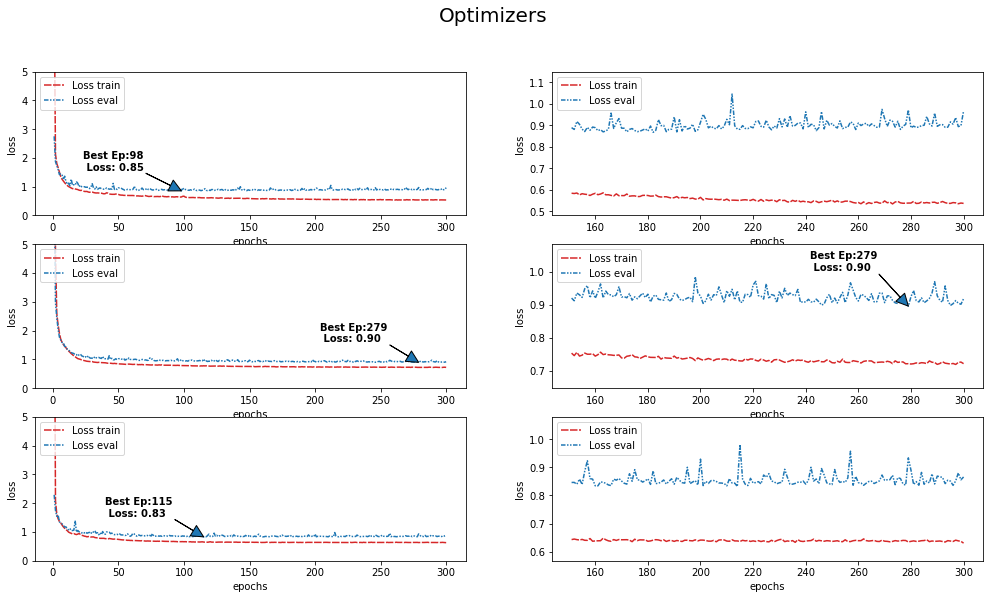

In [43]:
from collections import OrderedDict


start_epoch=0
y_max=5
title="BGR nano"

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])


model_runs = 115
dir_losses = root+"Datasets_STED/runs_transformers/STED_"+str(model_runs)+'_'+sub_name+'_'+obj+"_"+ch_name+"_"+loss_type+"_BitNet/"+'Losses.csv'

df = pd.read_csv(dir_losses)
losses_train = df['Losses train'][start_epoch:]
times_train = df['Times train'][start_epoch:]*1000 #ms
losses_eval = df['Losses eval'][start_epoch:]
times_eval = df['Times eval'][start_epoch:]*1000 #ms
l1_losses_box = df['L1 Losses cbbox'][start_epoch:]
l1_losses_conf = df['L1 Losses conf'][start_epoch:]
l2_losses_box = df['L2 Losses cbbox'][start_epoch:]
l2_losses_conf = df['L2 Losses conf'][start_epoch:]

epochs=len(losses_train)
x = range(1,epochs+1)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 9))
plt.rcParams.update({'font.size': 10})
#times = np.array(losses)/2

ax1 = axs[0][0]
color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(x, losses_train, color=color, linestyle=linestyles['densely dashed'], label="Loss train")
color = 'tab:blue'
ax1.plot(x, losses_eval, color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
ax1.tick_params(axis='y')
ax1.legend(loc="upper left")
ax1.axis(ymin=0, ymax=y_max)

y2 = min(losses_eval)
x2 = x[list(losses_eval).index(y2)]
ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-epochs/4,y2+y_max/7), weight="bold", arrowprops={'width':0.05})


start_plot = 1*epochs//2
ax1 = axs[0][1]
color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(x[start_plot:], losses_train[start_plot:], color=color, linestyle=linestyles['densely dashed'], label="Loss train")
color = 'tab:blue'
ax1.plot(x[start_plot:], losses_eval[start_plot:], color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
ax1.tick_params(axis='y')
ax1.legend(loc="upper left")

y_min2 = 0.9*min(losses_eval[start_plot:].min(), losses_train[start_plot:].min())
y_max2 = 1.1*max(losses_eval[start_plot:].max(), losses_train[start_plot:].min())
ax1.axis(ymin=y_min2, ymax=y_max2)
ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-(epochs-start_plot)/4,y2+(y_max2-y_min2)/4), weight="bold", arrowprops={'width':0.05})



model_runs = 117
dir_losses = root+"Datasets_STED/runs_transformers/STED_"+str(model_runs)+'_'+sub_name+'_'+obj+"_"+ch_name+"_"+loss_type+"_BitNet/"+'Losses.csv'

df = pd.read_csv(dir_losses)
losses_train = df['Losses train'][start_epoch:]
times_train = df['Times train'][start_epoch:]*1000 #ms
losses_eval = df['Losses eval'][start_epoch:]
times_eval = df['Times eval'][start_epoch:]*1000 #ms
l1_losses_box = df['L1 Losses cbbox'][start_epoch:]
l1_losses_conf = df['L1 Losses conf'][start_epoch:]
l2_losses_box = df['L2 Losses cbbox'][start_epoch:]
l2_losses_conf = df['L2 Losses conf'][start_epoch:]

ax1 = axs[1][0]
color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(x, losses_train, color=color, linestyle=linestyles['densely dashed'], label="Loss train")
color = 'tab:blue'
ax1.plot(x, losses_eval, color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
ax1.tick_params(axis='y')
ax1.legend(loc="upper left")
ax1.axis(ymin=0, ymax=y_max)

y2 = min(losses_eval)
x2 = x[list(losses_eval).index(y2)]
ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-epochs/4,y2+y_max/7), weight="bold", arrowprops={'width':0.05})


start_plot = 1*epochs//2
ax1 = axs[1][1]
color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(x[start_plot:], losses_train[start_plot:], color=color, linestyle=linestyles['densely dashed'], label="Loss train")
color = 'tab:blue'
ax1.plot(x[start_plot:], losses_eval[start_plot:], color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
ax1.tick_params(axis='y')
ax1.legend(loc="upper left")

y_min2 = 0.9*min(losses_eval[start_plot:].min(), losses_train[start_plot:].min())
y_max2 = 1.1*max(losses_eval[start_plot:].max(), losses_train[start_plot:].min())
ax1.axis(ymin=y_min2, ymax=y_max2)
ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-(epochs-start_plot)/4,y2+(y_max2-y_min2)/4), weight="bold", arrowprops={'width':0.05})


model_runs = 119
dir_losses = root+"Datasets_STED/runs_transformers/STED_"+str(model_runs)+'_'+sub_name+'_'+obj+"_"+ch_name+"_"+loss_type+"_BitNet/"+'Losses.csv'

df = pd.read_csv(dir_losses)
losses_train = df['Losses train'][start_epoch:]
times_train = df['Times train'][start_epoch:]*1000 #ms
losses_eval = df['Losses eval'][start_epoch:]
times_eval = df['Times eval'][start_epoch:]*1000 #ms
l1_losses_box = df['L1 Losses cbbox'][start_epoch:]
l1_losses_conf = df['L1 Losses conf'][start_epoch:]
l2_losses_box = df['L2 Losses cbbox'][start_epoch:]
l2_losses_conf = df['L2 Losses conf'][start_epoch:]

ax1 = axs[2][0]
color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(x, losses_train, color=color, linestyle=linestyles['densely dashed'], label="Loss train")
color = 'tab:blue'
ax1.plot(x, losses_eval, color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
ax1.tick_params(axis='y')
ax1.legend(loc="upper left")
ax1.axis(ymin=0, ymax=y_max)

y2 = min(losses_eval)
x2 = x[list(losses_eval).index(y2)]
ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-epochs/4,y2+y_max/7), weight="bold", arrowprops={'width':0.05})


start_plot = 1*epochs//2
ax1 = axs[2][1]
color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(x[start_plot:], losses_train[start_plot:], color=color, linestyle=linestyles['densely dashed'], label="Loss train")
color = 'tab:blue'
ax1.plot(x[start_plot:], losses_eval[start_plot:], color=color, linestyle=linestyles['densely dashdotdotted'], label="Loss eval")
ax1.tick_params(axis='y')
ax1.legend(loc="upper left")

y_min2 = 0.9*min(losses_eval[start_plot:].min(), losses_train[start_plot:].min())
y_max2 = 1.1*max(losses_eval[start_plot:].max(), losses_train[start_plot:].min())
ax1.axis(ymin=y_min2, ymax=y_max2)
ax1.annotate('Best Ep:{0:d}\n Loss: {1:0.2f}'.format(x2, y2),xy=(x2,y2),xytext=(x2-(epochs-start_plot)/4,y2+(y_max2-y_min2)/4), weight="bold", arrowprops={'width':0.05})


fig.suptitle('Optimizers', fontsize = 20)
plt.savefig(folder_save_results+"optimizers.png", format="png", dpi=400)
#if folder_to_save!=None:
#    plt.savefig(folder_to_save, format="png", dpi=dpi)
#plt.close(fig)
#return fig

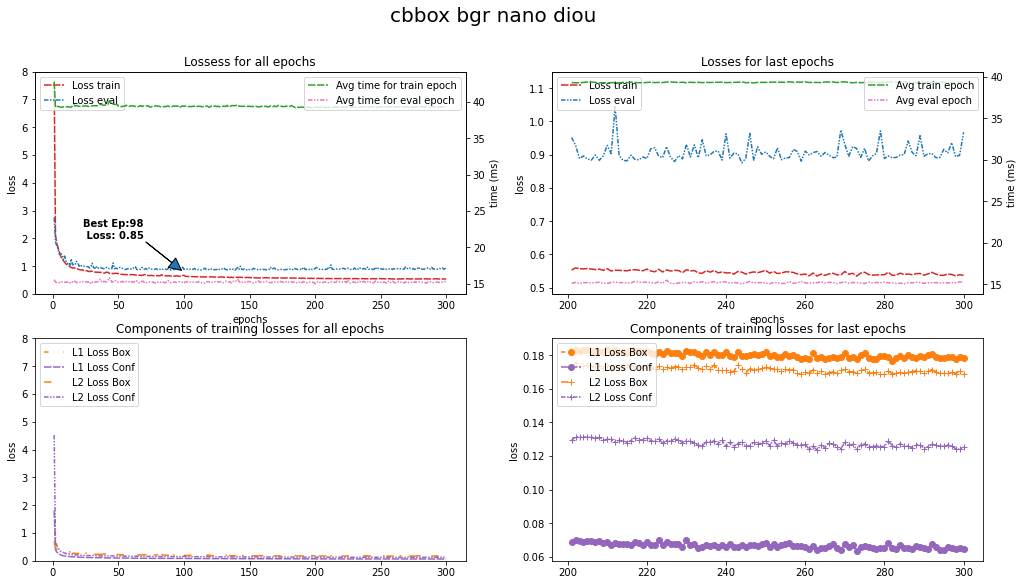

In [25]:
model_runs = 115 #bbox diou
sub_name = 'nano'
obj = 'cbbox'
ch_name = 'bgr'
loss_type= 'diou'
ch_name = 'bgr'
title = obj+' '+ch_name+' '+sub_name+' '+loss_type

dir_losses1 = root+"Datasets_STED/runs_transformers/STED_"+str(model_runs)+'_'+sub_name+'_'+obj+"_"+ch_name+"_"+loss_type+"_BitNet/"+'Losses.csv'
fig = plots.plot_train_losses(dir_losses, title, folder_save_results, y_max=8)
fig

# YOLO test

In [ ]:
from ultralytics import YOLO
import time
from model.trainer import count_parameters
from model.trainer import model_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 224
#imgnp = cv2.imread("Zone3_bgr.png")
zone_name = 'Zone108_octubre'
#zone_name = 'Zone3'
folder_maps = root+'Datasets Maps/'

models_dir = [root+'Datasets_YOLO/runs/detect/train2/weights/best.pt',
              root+'Datasets_YOLO/runs/detect/train4/weights/best.pt',
              root+'Datasets_YOLO/runs/detect/train3/weights/best.pt',
              root+'Datasets_YOLO/runs/detect/train5/weights/best.pt'
              #'Datasets_YOLO/runs/segment/train2/weights/best.pt',
              #'Datasets_YOLO/runs/segment/train5/weights/best.pt',
              #'Datasets_YOLO/runs/segment/train6/weights/best.pt'
             ]
maps_dir = [folder_maps+zone_name+'_full.tif',
            folder_maps+zone_name+'_full.tif',
            folder_maps+zone_name+'_full.tif',
            folder_maps+zone_name+'_full.tif'
            #folder_maps+zone_name+"_bgr_improved.png",
            #folder_maps+zone_name+"_bgr.png",
            #folder_maps+zone_name+"_bgr_improved.png"
           ]

dat = []
boxes_c = [] #to save filtered boxes of each model

for model_dir, map_dir in zip(models_dir, maps_dir):
    model = YOLO(model_dir)

    
    #imgnp = cv2.imread(map_dir)
    with rio.open(map_dir) as img :
        imgnp = img.read() 
    
    f = open(root+'zone_parameters.json'); zone_parameters = json.load(f); f.close()
    correctionRGB = zone_parameters[zone_name]['correctionRGB']

    imgnp = imgnp[0:3,::] #select bgr channels, shape Nchannels x H x W
    imgnp = imgnp.transpose(1, 2, 0)#/img.max() #change to H x W x Nchannels
    
    imgnp = imgnp/correctionRGB
    imgnp = (255*imgnp).astype('uint8')
           
    all_boxes = torch.tensor([]).to('cuda')
    all_scores = torch.tensor([]).to('cuda')
    all_categories = torch.tensor([]).to('cuda')
    #all_masks = []
    time_avg_pred = []

    for i in range(0, imgnp.shape[0], img_size//2):
        for j in range(0, imgnp.shape[1], img_size//2):
            i2 = i+img_size if i+img_size <= imgnp.shape[0] else imgnp.shape[0]
            j2 = j+img_size if j+img_size <= imgnp.shape[1] else imgnp.shape[1]

            print('\r', "Tile %d:%d, %d:%d"%(i, i2, j, j2), end='')
            im = np.zeros((img_size, img_size, imgnp.shape[-1]))
            im[0:i2-i, 0:j2-j, :] = imgnp[i:i2,j:j2, :]
            
            start_b = time.time()
            results = model(im, verbose = False)  # predict on an image
            
            boxes = results[0].boxes.xyxy
            scores = results[0].boxes.conf #scores of boxes
            category = results[0].boxes.cls
            #update boxes to orthomosaic map
            x1 = (boxes[:,0]+(j)).view(-1, 1)
            y1 = (boxes[:,1]+(i)).view(-1, 1)
            x2 = (boxes[:,2]+(j)).view(-1, 1)
            y2 = (boxes[:,3]+(i)).view(-1, 1)
            boxes = torch.concat((x1, y1, x2, y2), axis=1)
            #mask = results[0].masks.xy if results[0].masks else None
            end_b = time.time()
            time_avg_pred.append(end_b-start_b)

            all_boxes = torch.concat((all_boxes, boxes))
            all_scores = torch.concat((all_scores, scores))
            all_categories = torch.concat((all_categories, category))
            #if mask:
            #    for contour in mask:
            #        c_ = contour
            #        c_[:,0] = contour[:,0]+(j-img_size)
            #        c_[:,1] = contour[:,1]+(i-img_size)
            #        all_masks.append(c_.astype('int'))

    print(all_boxes.shape)
    index_filter_boxes = utils.utils.non_max_suppression_area(all_boxes, all_scores, iou_threshold=0.5, obj='bbox', device=device)
    N_boxes = len(index_filter_boxes)
    print(N_boxes)
    boxes_filtered = all_boxes[[index_filter_boxes]]
    scores_filtered = all_scores[[index_filter_boxes]]
    categories_filtered=1
    obj = 'bbox'
    
    ############ Object Detection Metrics ##############################
    file_name = folder_maps + zone_name + "_labels.txt"
    boxes_gt = torch.tensor([]).to(device)
    classes_gt = torch.tensor([]).to(device)
    areas_gt = np.array([])
    with open(file_name, "r") as f:
        lines = f.readlines()
    for line in lines:
        data = np.fromstring(line, sep=' ')
        
        box_gt = torch.tensor(np.array([data[1:5]])).to(device)
        class_gt = torch.tensor(np.array([data[0]])).to(device)
        area_gt = cv2.contourArea(data[9:].reshape(-1, 2).astype('int'))          #area

        boxes_gt = torch.concat((boxes_gt, box_gt))
        classes_gt = torch.concat((classes_gt, class_gt))
        areas_gt = np.append(areas_gt, area_gt)
        
    mAP50, N_agaves_mAP50 = utils.utils.mAP(boxes_gt, boxes_filtered, classes_gt, categories_filtered, num_classes=1, scores=scores_filtered, obj=obj, iou_thr=0.5, device=device)
    mAP75, N_agaves_mAP75 = utils.utils.mAP(boxes_gt, boxes_filtered, classes_gt, categories_filtered, num_classes=1, scores=scores_filtered, obj=obj, iou_thr=0.75, device=device)
    mAP95, N_agaves_mAP95 = utils.utils.mAP(boxes_gt, boxes_filtered, classes_gt, categories_filtered, num_classes=1, scores=scores_filtered, obj=obj, iou_thr=0.95, device=device)

    #error_mAP50 = '%1.2f%%' %(((N_agaves_mAP50-3583)/3583)*100)
    N_agaves_real = boxes_gt.shape[0]
    error_mAP50 = ((N_agaves_mAP50-N_agaves_real)/N_agaves_real)*100
    error_mAP75 = ((N_agaves_mAP75-N_agaves_real)/N_agaves_real)*100
    error_mAP95 = ((N_agaves_mAP95-N_agaves_real)/N_agaves_real)*100

    #detection metrics
    sort_index = scores_filtered.argsort(descending=True) #sort of the largest score to the smallest
    boxes_pred = boxes_filtered[sort_index]
    #classes_pred = categories_filtered[sort_index]
    classes_pred = torch.zeros_like(scores_filtered)
    iou_thr = 0.5
    average_precisions = []
    epsilon = 1e-6
    corrects=0
    
    #Get ground truth data considering only one class
    for c in range(1):
        boxes_gt_c = torch.tensor([]).to(device)
        boxes_pred_c = torch.tensor([]).to(device)
        for box_gt, class_gt in zip(boxes_gt, classes_gt):
            if class_gt == c:
                boxes_gt_c = torch.concat((boxes_gt_c, box_gt.unsqueeze(0) ))
        for box_pred, class_pred in zip(boxes_pred, classes_pred):
            if class_pred == c:
                boxes_pred_c = torch.concat((boxes_pred_c, box_pred.unsqueeze(0) ))

        if obj == 'bbox':
            ious = utils.utils.bbox_iou(boxes_gt_c, boxes_pred_c, x1y1x2y2=True, align=False, DIoU = False)
        else:
            ious = utils.utils.cbbox_iou(boxes_gt_c, boxes_pred_c, align=False, DIoU = False)
        
        ###################### Detection for min overlap ###########################
        ious_filter = ious.where(ious>0,torch.tensor(0.)) #match with some overlap
        mappings = utils.utils.get_mappings(ious_filter)

        TP_index = mappings.sum(0).eq(1).long() #sum cols and select only the results eq to 1 and conver boolean to long : array of len of predictions
        FP_index = mappings.sum(0).eq(0).long() #sum cols and select only the results eq to 0 and conver boolean to long : array of len of predictions
        FN_index = mappings.sum(1).eq(0).long() #sum rows and select only the results eq to 0 and conver boolean to long : array of len of ground truths

        TP_index = torch.where(TP_index[sort_index.argsort()])[0]
        FP_index = torch.where(FP_index[sort_index.argsort()])[0]
        FN_index = torch.where(FN_index)[0]
        
        ###################### Detection according diou_thr 0.5 ###########################
        ious_filter = ious.where(ious>iou_thr,torch.tensor(0.)) #match with some overlap
        mappings = utils.utils.get_mappings(ious_filter)

        TP_index2 = mappings.sum(0).eq(1).long() #sum cols and select only the results eq to 1 and conver boolean to long : array of len of predictions
        FP_index2 = mappings.sum(0).eq(0).long() #sum cols and select only the results eq to 0 and conver boolean to long : array of len of predictions
        FN_index2 = mappings.sum(1).eq(0).long() #sum rows and select only the results eq to 0 and conver boolean to long : array of len of ground truths

        TP_index2 = torch.where(TP_index2[sort_index.argsort()])[0]
        FP_index2 = torch.where(FP_index2[sort_index.argsort()])[0]
        FN_index2 = torch.where(FN_index2)[0]
        
        ###################### Detection according diou_thr 0.75 ###########################
        ious_filter = ious.where(ious>0.75,torch.tensor(0.)) #match with some overlap
        mappings = utils.utils.get_mappings(ious_filter)

        TP_index3 = mappings.sum(0).eq(1).long() #sum cols and select only the results eq to 1 and conver boolean to long : array of len of predictions
        FP_index3 = mappings.sum(0).eq(0).long() #sum cols and select only the results eq to 0 and conver boolean to long : array of len of predictions
        FN_index3 = mappings.sum(1).eq(0).long() #sum rows and select only the results eq to 0 and conver boolean to long : array of len of ground truths

        TP_index3 = torch.where(TP_index3[sort_index.argsort()])[0]
        FP_index3 = torch.where(FP_index3[sort_index.argsort()])[0]
        FN_index3 = torch.where(FN_index3)[0]
    
    ###################### Detection for min overlap ###########################
    d_recall = len(TP_index)/(len(TP_index)+len(FN_index)) if (len(TP_index)+len(FN_index))!=0 else 1
    d_precision = len(TP_index)/(len(TP_index)+len(FP_index)) if (len(TP_index)+len(FP_index))!=0 else 1
    d_f1 = (2*d_precision*d_recall)/(d_precision+d_recall)
    d_recall*=100; d_precision*=100; d_f1*=100
    
    ###################### Detection according diou_thr 0.5 ###########################
    d_recall2 = len(TP_index2)/(len(TP_index2)+len(FN_index2)) if (len(TP_index2)+len(FN_index2))!=0 else 1
    d_precision2 = len(TP_index2)/(len(TP_index2)+len(FP_index2)) if (len(TP_index2)+len(FP_index2))!=0 else 1
    d_f12 = (2*d_precision2*d_recall2)/(d_precision2+d_recall2)
    d_recall2*=100; d_precision2*=100; d_f12*=100
    
    ###################### Detection according diou_thr 0.75 ###########################
    d_recall3 = len(TP_index3)/(len(TP_index3)+len(FN_index3)) if (len(TP_index3)+len(FN_index3))!=0 else 1
    d_precision3 = len(TP_index3)/(len(TP_index3)+len(FP_index3)) if (len(TP_index3)+len(FP_index3))!=0 else 1
    d_f13 = (2*d_precision3*d_recall3)/(d_precision3+d_recall3)
    d_recall3*=100; d_precision3*=100; d_f13*=100
    
    ###################### Save results ###########################
    final_result = (zone_name, boxes_filtered, scores_filtered, boxes_gt, TP_index, FP_index, FN_index, TP_index2, FP_index2, FN_index2, TP_index3, FP_index3, FN_index3)
    #final_results.append(final_result)
    
    n_pars = count_parameters(model, False)
    n_size_mb = model_size(model)
    time_avg_pred = np.array(time_avg_pred).mean()
    
    data = np.array([int(len(scores_filtered)), N_agaves_real, n_pars, np.round(n_size_mb, 3), np.round(time_avg_pred*1000, 2), np.round(mAP50, 2), int(N_agaves_mAP50), 
                     np.round(mAP75, 2), int(N_agaves_mAP75), np.round(mAP95, 2), int(N_agaves_mAP95),
                     np.round(d_recall, 2), np.round(d_precision, 2), np.round(d_f1, 2),
                     np.round(d_recall2, 2), np.round(d_precision2, 2), np.round(d_f12, 2),
                     np.round(d_recall3, 2), np.round(d_precision3, 2), np.round(d_f13, 2),
                     len(TP_index), len(FP_index), len(FN_index) ])

    dat.append(data)
    print(map_dir+' finished')

In [ ]:
import pandas as pd
df = pd.DataFrame(dat, columns=[ 'N detected objects', 'N agaves real', 'N pars', 'N size (mb)', 'T image pred (ms)',
                                 'mAP50 (%)', 'N agaves mAP50', 'mAP75 (%)', 'N agaves mAP75',
                                 'mAP95 (%)', 'N agaves mAP95',
                                 'Recall (%)', 'Precision (%)', 'F1 (%)', 
                                 'Recall\' 50 (%)', 'Precision\' 50 (%)', 'F1\' 50 (%)', 
                                 'Recall\'\' 75 (%)', 'Precision\'\' 75 (%)', 'F1\'\' 75 (%)', 
                                 'TP\'', 'FP\'', 'FN\''], 
                        #index = [ 'BBOX diou', 'CBBOX diou', 'BBOX diou bgrvis_shatt', 'CBBOX diou bgrvis_shatt', 'BBOX diou bgrvis', 'CBBOX diou bgrvis'])
                        index = [ 'YOLO Nano 100', 'YOLO Nano 200', 'YOLO Medium 100', 'YOLO Medium 200'])
                        #index = [ 'BBOX diou bgrvis'])
                        #index = [ 'BBOX diou', 'CBBOX diou'])
                        #index = [ 'BBOX diou bgrvis', 'CBBOX diou bgrvis'])
                        #index = [ 'BBOX diou bgrvis_shatt', 'CBBOX diou bgrvis_shatt'])
                        #index = [ 'CBBOX MSE', 'CBBOX DIOU'])
folder_save_results = root+'Counting results/'
df.to_csv(folder_save_results+'counting_results_YOLO_'+zone_name+'.csv')
print(df['N agaves real'][0])
cols = ['N detected objects', 'N pars', 'N size (mb)', 'T image pred (ms)',
                                 'mAP50 (%)', 'N agaves mAP50', 'mAP75 (%)', 'N agaves mAP75',
                                 #'mAP95 (%)', 'N agaves mAP95',
                                 'Recall (%)', 'Precision (%)', 'F1 (%)', 
                                 'Recall\' 50 (%)', 'Precision\' 50 (%)', 'F1\' 50 (%)', 
                                 #'Recall\'\' 75 (%)', 'Precision\'\' 75 (%)', 'F1\'\' 75 (%)', 
                                 'TP\'', 'FP\'', 'FN\'']
df[cols]

# Others

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import rasterio as rio

# bounding box colormap 설정
cmap = np.array(plt.cm.get_cmap('Paired').colors)
cmap_rgb: list = np.multiply(cmap, 255).astype(np.int32).tolist()
plt.figure(figsize=(16, 8))
# 결과 이미지를 저장하는 코드
#os.makedirs(args.save_folder, exist_ok=True)
for i, (path, img, prediction) in enumerate(zip(img_paths, images, img_predictions) ):
    print(i)
    # 원본 이미지 열기
    #path = path.replace('\\', '/')
    #image = Image.open(path).convert('RGB')
    #with rio.open(path) as img :
    #    image = img.read()[0:3,:,:]
    #image = Image.fromarray((image.transpose(1, 2, 0))[:,:,[0,1,2]].astype('uint8'))
    image = Image.fromarray(np.array((img.permute(1, 2, 0))[:,:,[2,1,0]].cpu()).astype('uint8'))
    print("image range, max "+ str(img.max()))
    draw = ImageDraw.Draw(image)

    if prediction is not None:
        # 원본 이미지로 bounding box를 rescale한다.
        #prediction = utils.utils.rescale_boxes_original(prediction, 224, image.size)

        for x1, y1, x2, y2, obj_conf, cls_conf, cls_pred in prediction:
            # bounding box color 설정
            color = tuple(cmap_rgb[int(cls_pred) % len(cmap_rgb)])

            # bounding box 그리기
            draw.rectangle(((x1, y1), (x2, y2)), outline=color, width=2)

            # label 그리기
            text = '{} {:.1f}'.format(" ", obj_conf.item() * 100)
            font = ImageFont.truetype('calibri.ttf', size=12)
            text_width, text_height = font.getsize(text)
            draw.rectangle(((x1, y1), (x1 + text_width, y1 + text_height)), fill=color)
            draw.text((x1, y1), text, fill=(0, 0, 0), font=font)
    plt.subplot(2, 4, i+1)
    plt.imshow(image); plt.axis('off')
